# Débug

In [1]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.19.0rc0)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.10.0rc0, 2.10.0rc1, 2.10.0, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0rc3, 2.11.0, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.1rc0, 2.13.1rc1, 2.13.1, 2.1

# Prétraitement

## Redimension

In [7]:
import os
from PIL import Image

# Dossiers de base
base_folders = {
    "left": "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train",
    "gt": "/Users/kevinroualec/Desktop/imgp8/gtFine/train"
}

# Création des dossiers de sortie "resized" pour chaque dossier train
output_folders = {key: os.path.join(folder, "resized") for key, folder in base_folders.items()}
for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

# Vérification si c'est une image gtFine
def is_gtfine_image(filename):
    return filename.lower().endswith('gtfine_labelids.png')

# Stocker les images groupées par leur préfixe
grouped_images = {}

# Exploration des dossiers
for key, folder in base_folders.items():
    for city in os.listdir(folder):
        city_path = os.path.join(folder, city)
        if not os.path.isdir(city_path):
            continue

        for image_file in os.listdir(city_path):
            if key == "gt" and not is_gtfine_image(image_file):
                continue
            if key == "left" and not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            prefix = "_".join(image_file.split('_')[:3])
            grouped_images.setdefault(prefix, {"left": None, "gt": None})
            image_path = os.path.join(city_path, image_file)

            if key == "left":
                grouped_images[prefix]["left"] = image_path
            else:
                grouped_images[prefix]["gt"] = image_path

# Traitement et sauvegarde
for prefix, images in grouped_images.items():
    left_path, gt_path = images["left"], images["gt"]

    if left_path and gt_path:
        try:
            left_image = Image.open(left_path).resize((1024, 512))
            save_path = os.path.join(output_folders["left"], f"{prefix}_leftImg8bit.png")
            left_image.save(save_path)
            #print(f"Image gauche {prefix} redimensionnée et sauvegardée.")
        except Exception as e:
            print(f"Erreur avec l'image gauche {prefix}: {e}")

        try:
            gt_image = Image.open(gt_path).resize((1024, 512), Image.NEAREST)
            save_path = os.path.join(output_folders["gt"], f"{prefix}_gtFine_labelIds.png")
            gt_image.save(save_path)
            #print(f"Image gtFine {prefix} redimensionnée et sauvegardée.")
        except Exception as e:
            print(f"Erreur avec l'image gtFine {prefix}: {e}")
    else:
        print(f"Paire incomplète pour le préfixe {prefix}. Redimensionnement ignoré.")

print("Redimensionnement terminé avec succès.")


Redimensionnement terminé avec succès.


# Unet

## Sans augmentation

U-Net model compiled successfully with CategoricalCELoss.
Toutes les paires image/mask correspondent.
Les paires image/mask d'entraînement sont correctement appariées.
Toutes les paires image/mask correspondent.
Les paires image/mask de validation sont correctement appariées.
Number of training images: 2975
Number of training masks: 2975
Number of validation images: 500
Number of validation masks: 500
Epoch 1/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5457 - f1-score: 0.2585 - iou_score: 0.1862 - loss: 0.1713
Epoch 1: iou_score improved from -inf to 0.25594, saving model to unet_model_best_iou.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 1368s 7s/step - accuracy: 0.5462 - f1-score: 0.2588 - iou_score: 0.1866 - loss: 0.1711 - val_accuracy: 0.2151 - val_f1-score: 0.1140 - val_iou_score: 0.0303 - val_loss: 0.2650 - learning_rate: 0.0100
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7330 - f1-score: 0.4325 - iou_score: 0.3709 - loss: 0.0999
Epoch 2: iou_score impro

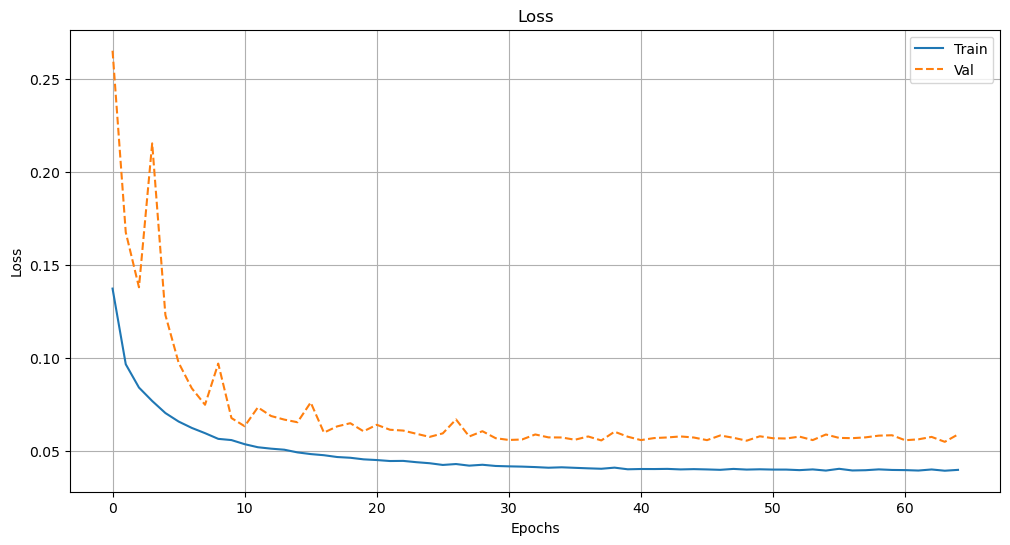

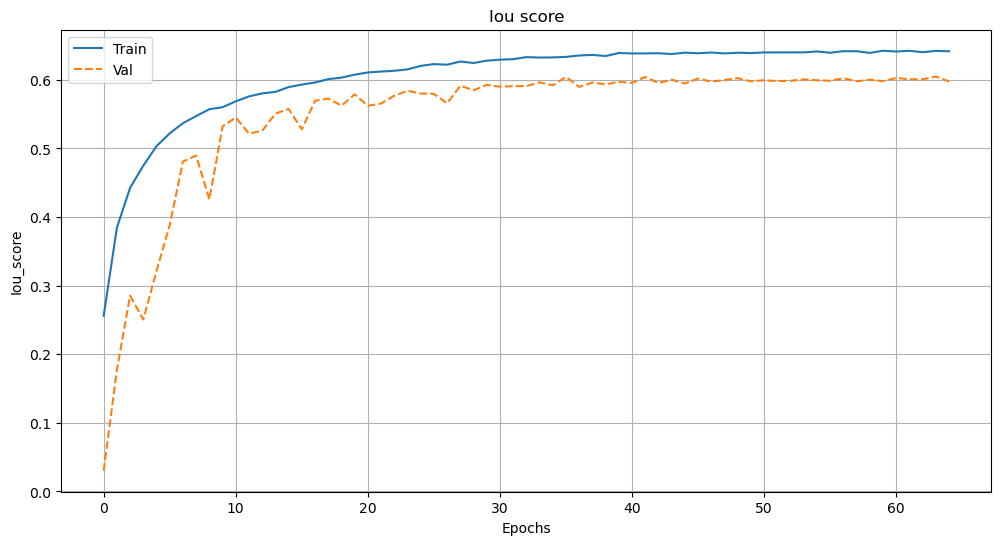

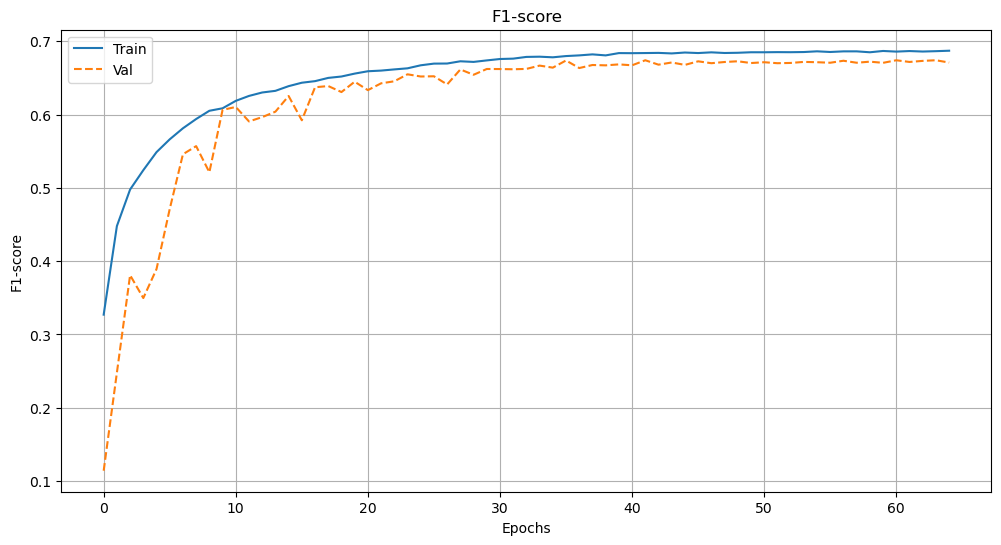

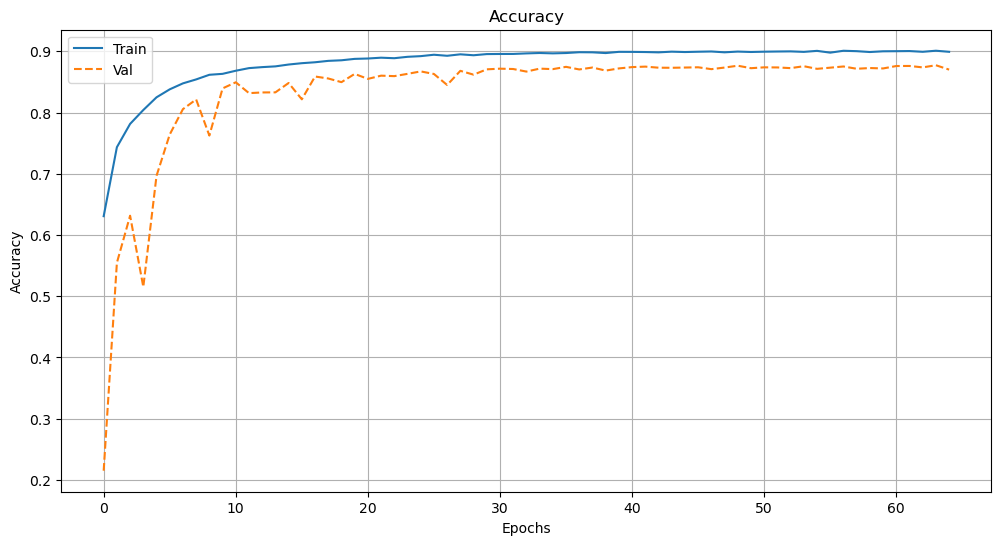

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


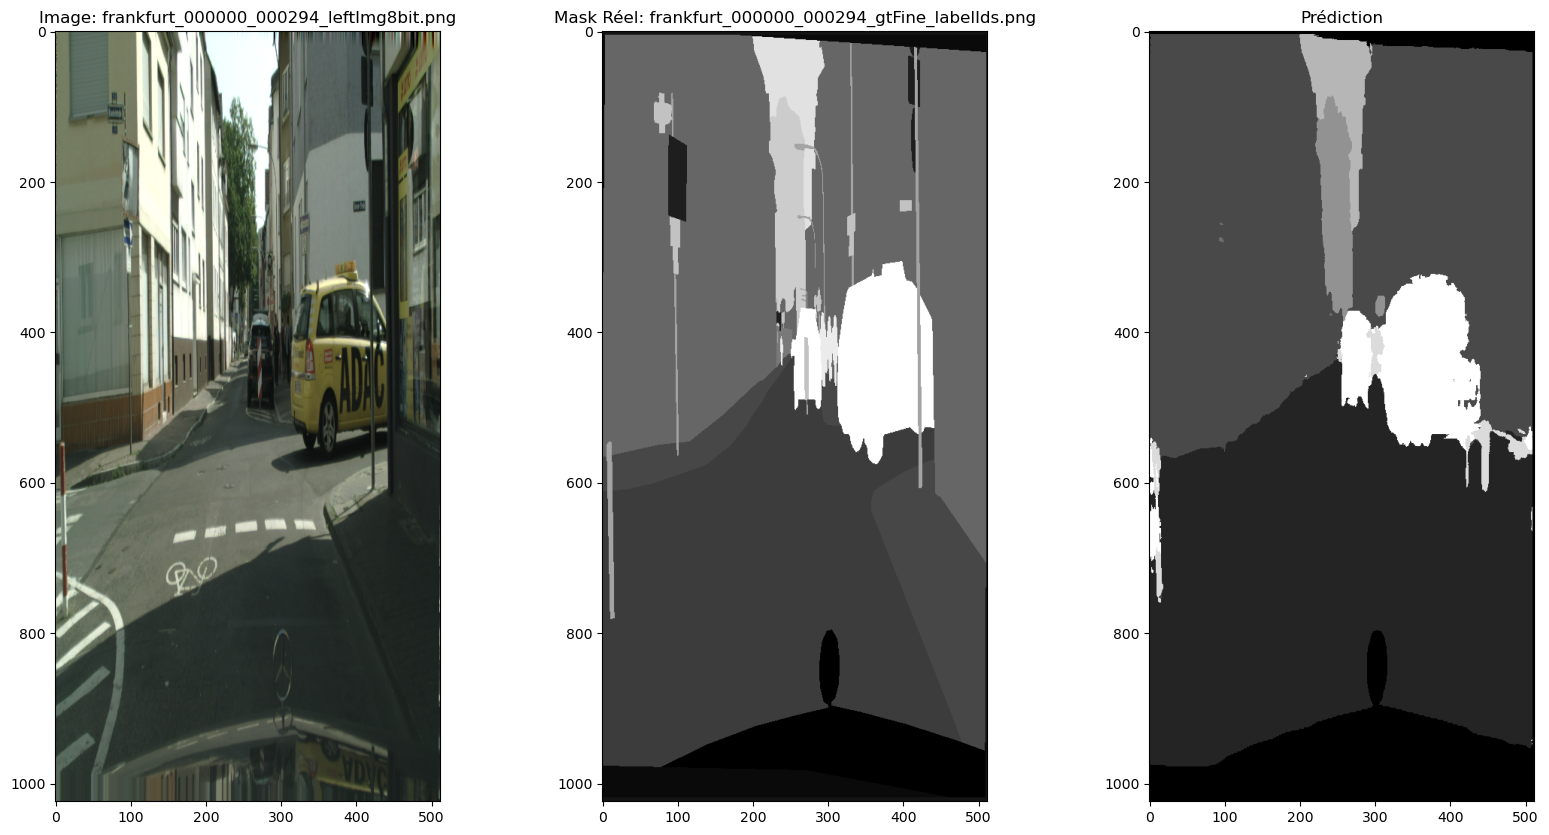

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from collections import namedtuple
import segmentation_models as sm
from tensorflow.keras.utils import to_categorical

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

# Fonction pour récupérer les chemins d'image dans les sous-dossiers
def get_paths(directory, file_suffix):
    paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(file_suffix):
                paths.append(os.path.join(root, file))
    return paths

# Fonction pour vérifier les paires image/mask
def verify_image_mask_pairs(image_paths, mask_paths):
    if len(image_paths) != len(mask_paths):
        print("Erreur : Le nombre d'images et de masques ne correspond pas.")
        return False

    for image_path, mask_path in zip(image_paths, mask_paths):
        image_name = os.path.basename(image_path)
        mask_name = os.path.basename(mask_path)

        image_prefix = image_name.split('_leftImg8bit.png')[0]
        mask_prefix = mask_name.split('_gtFine_labelIds.png')[0]

        if image_prefix != mask_prefix:
            print(f"Erreur : L'image {image_name} ne correspond pas au masque {mask_name}.")
            return False

    print("Toutes les paires image/mask correspondent.")
    return True

# Fonction pour charger et normaliser les images
def load_image(image_path):
    try:
        img = keras.preprocessing.image.load_img(image_path, target_size=(1024, 512))
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255.0
        return img.astype(np.float32)
    except Exception as e:
        print(f"Warning: {image_path} is corrupted or cannot be loaded. Skipping this file.")
        return None

# Fonction pour charger les masques
def load_mask(mask_path):
    try:
        img = keras.preprocessing.image.load_img(mask_path, target_size=(1024, 512), color_mode="grayscale")
        img = keras.preprocessing.image.img_to_array(img)
        return img.astype(np.float32)
    except Exception as e:
        print(f"Warning: {mask_path} is corrupted or cannot be loaded. Skipping this file. Error: {e}")
        return None

# Fonction pour appliquer le mappage des catégories sur le masque
def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)
    for label in labels:
        new_mask[mask == label.id] = label.categoryId
    return new_mask.astype(np.uint8)

# Fonction de visualisation pour afficher l'image et son masque côte à côte
def visualize_sample(image, mask, image_path, mask_path):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(image.astype('uint8'))
    axs[0].set_title(f'Image: {os.path.basename(image_path)}')
    axs[0].axis('off')
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title(f'Mask: {os.path.basename(mask_path)}')
    axs[1].axis('off')
    plt.show()

def data_generator(image_paths, mask_paths, batch_size, visualize=False):
    index = 0
    first_batch = True

    if not image_paths or not mask_paths:
        print("Warning: No data available for generating batches.")
        return

    shuffle_indices = np.arange(len(image_paths))
    np.random.shuffle(shuffle_indices)

    while True:
        batch_images = []
        batch_masks = []

        for _ in range(batch_size):
            if index >= len(image_paths):
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]
            mask_path = mask_paths[shuffled_idx]

            img = load_image(image_path)
            mask = load_mask(mask_path)

            if img is None or mask is None:
                index += 1
                continue

            if img.shape[:2] != mask.shape[:2]:
                print(f"Warning: Image and mask dimensions do not match for {image_path}")
                index += 1
                continue

            mask = apply_category_mapping(mask)
            mask = to_categorical(mask, num_classes=8).astype(np.float32)

            if img.shape[:2] != (1024, 512) or mask.shape[:2] != (1024, 512):
                print(f"Warning: Image or mask dimensions are incorrect for {image_path}")
                index += 1
                continue

            batch_images.append(img)
            batch_masks.append(mask)

            index += 1

        if not batch_images or not batch_masks:
            print("Warning: Empty batch generated")
            continue

        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):
                visualize_sample(batch_images[i], np.argmax(batch_masks[i], axis=-1), image_path, mask_path)
            first_batch = False

        yield np.array(batch_images), np.array(batch_masks)

def optimized_unet_model(dropout_rate=0.3):
    inputs = layers.Input((1024, 512, 3))

    # Contracting path
    c1 = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Dropout(dropout_rate)(c1)
    c1 = layers.Conv2D(16, (3, 3), padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Dropout(dropout_rate)(c2)
    c2 = layers.Conv2D(32, (3, 3), padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Dropout(dropout_rate)(c3)
    c3 = layers.Conv2D(64, (3, 3), padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Dropout(dropout_rate)(c4)
    c4 = layers.Conv2D(128, (3, 3), padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Dropout(dropout_rate)(c5)
    c5 = layers.Conv2D(256, (3, 3), padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    # Expanding path
    u6 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(128, (3, 3), padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Dropout(dropout_rate)(c6)
    c6 = layers.Conv2D(128, (3, 3), padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    u7 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(64, (3, 3), padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Dropout(dropout_rate)(c7)
    c7 = layers.Conv2D(64, (3, 3), padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)

    u8 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(32, (3, 3), padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Dropout(dropout_rate)(c8)
    c8 = layers.Conv2D(32, (3, 3), padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)

    u9 = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(16, (3, 3), padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Dropout(dropout_rate)(c9)
    c9 = layers.Conv2D(16, (3, 3), padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)

    outputs = layers.Conv2D(8, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs, outputs)
    return model

# Initialisation des métriques de segmentation
iou_metric = sm.metrics.IOUScore(threshold=0.5)
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur
initial_learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Initialisation du modèle
model = optimized_unet_model()

# Compilation du modèle avec les métriques de segmentation et la perte CategoricalCELoss
model.compile(
    optimizer=optimizer,
    loss=sm.losses.CategoricalCELoss(),
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

print("U-Net model compiled successfully with CategoricalCELoss.")

# Paramètres d'entraînement
batch_size = 16
epochs = 100

# Récupération des images et masques pour l'entraînement et la validation
train_images_paths = get_paths(train_images_dir_left, "_leftImg8bit.png")
train_mask_paths = get_paths(train_images_dir_gtfine, "_gtFine_labelIds.png")

val_images_paths = get_paths(val_images_dir_left, "_leftImg8bit.png")
val_mask_paths = get_paths(val_images_dir_gtfine, "_gtFine_labelIds.png")

# Triez les chemins pour vous assurer qu'ils sont dans le même ordre
train_images_paths.sort()
train_mask_paths.sort()
val_images_paths.sort()
val_mask_paths.sort()

# Vérification des paires image/mask
if verify_image_mask_pairs(train_images_paths, train_mask_paths):
    print("Les paires image/mask d'entraînement sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask d'entraînement.")

if verify_image_mask_pairs(val_images_paths, val_mask_paths):
    print("Les paires image/mask de validation sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask de validation.")

# Vérification des chemins d'images et de masques
print(f"Number of training images: {len(train_images_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_images_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

# Générateurs de données pour l'entraînement et la validation
train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

callbacks = [
    ModelCheckpoint('unet_model_best_iou.keras', monitor='iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='iou_score', factor=0.25, patience=2, verbose=1),
    EarlyStopping(monitor='iou_score', mode='max', patience=5, verbose=1),
    keras.callbacks.LearningRateScheduler(lambda epoch: initial_learning_rate * (0.9 ** epoch))
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // batch_size,
    validation_data=val_gen if len(val_images_paths) > 0 else None,
    validation_steps=len(val_images_paths) // batch_size if len(val_images_paths) > 0 else None,
    epochs=epochs,
    callbacks=callbacks
)

# Visualisation des métriques
def plot_metrics(history):
    metrics = ['loss', 'iou_score', 'f1-score', 'accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history[metric], label='Train')
        if 'val_' + metric in history.history:
            plt.plot(history.history['val_' + metric], label='Val', linestyle='--')
        plt.title(metric.replace('_', ' ').capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

plot_metrics(history)

def load_and_preprocess_image(image_path, target_size=(1024, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_and_preprocess_mask(mask_path, target_size=(1024, 512)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size, method='nearest')
    mask = tf.cast(mask, tf.int32)
    return mask

def visualize_prediction(image_path, mask_path, model):
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_mask = np.argmax(prediction, axis=-1)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title(f"Mask Réel: {os.path.basename(mask_path)}")
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')
    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)


## Avec augmentation

U-Net model compiled successfully with CategoricalCELoss.
Toutes les paires image/mask correspondent.
Les paires image/mask d'entraînement sont correctement appariées.
Toutes les paires image/mask correspondent.
Les paires image/mask de validation sont correctement appariées.
Number of training images: 2975
Number of training masks: 2975
Number of validation images: 500
Number of validation masks: 500
Epoch 1/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6071 - f1-score: 0.3131 - iou_score: 0.2377 - loss: 0.1398 
Epoch 1: iou_score improved from -inf to 0.30613, saving model to unet_model_best_iou_aug.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 5137s 14s/step - accuracy: 0.6073 - f1-score: 0.3132 - iou_score: 0.2379 - loss: 0.1398 - val_accuracy: 0.3471 - val_f1-score: 0.2324 - val_iou_score: 0.1627 - val_loss: 0.3502 - learning_rate: 0.0100
Epoch 2/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7404 - f1-score: 0.4575 - iou_score: 0.4006 - loss: 0.0938 
Epoch 2: iou_sc

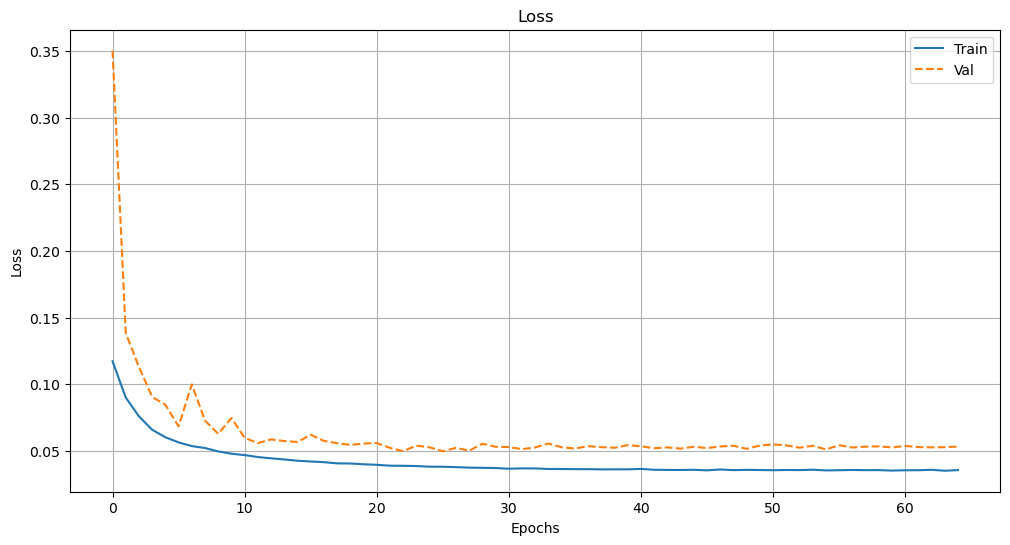

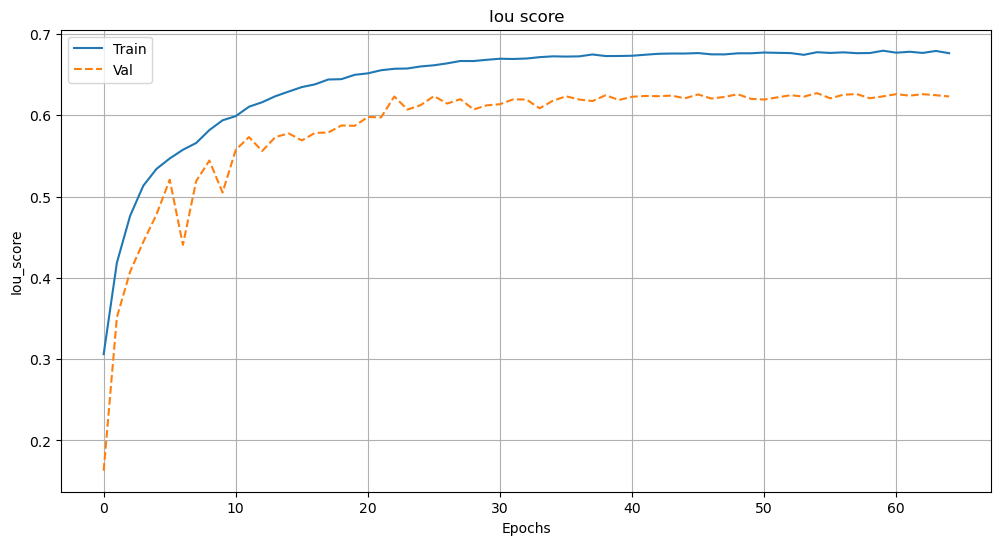

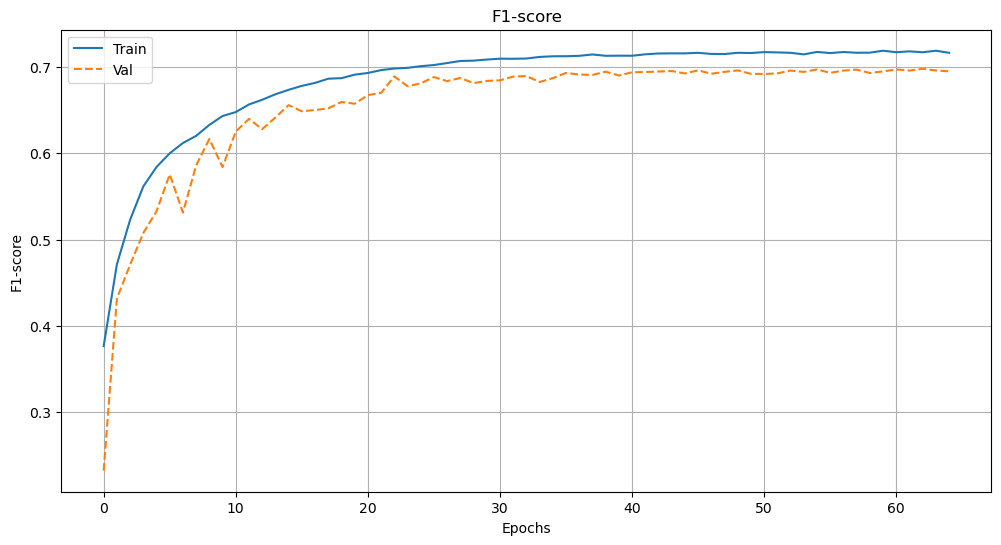

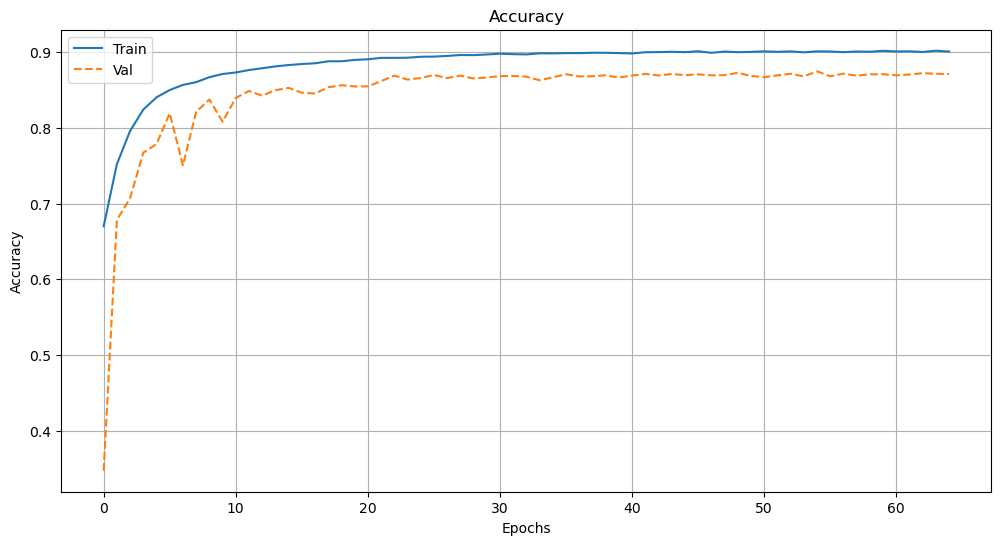

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


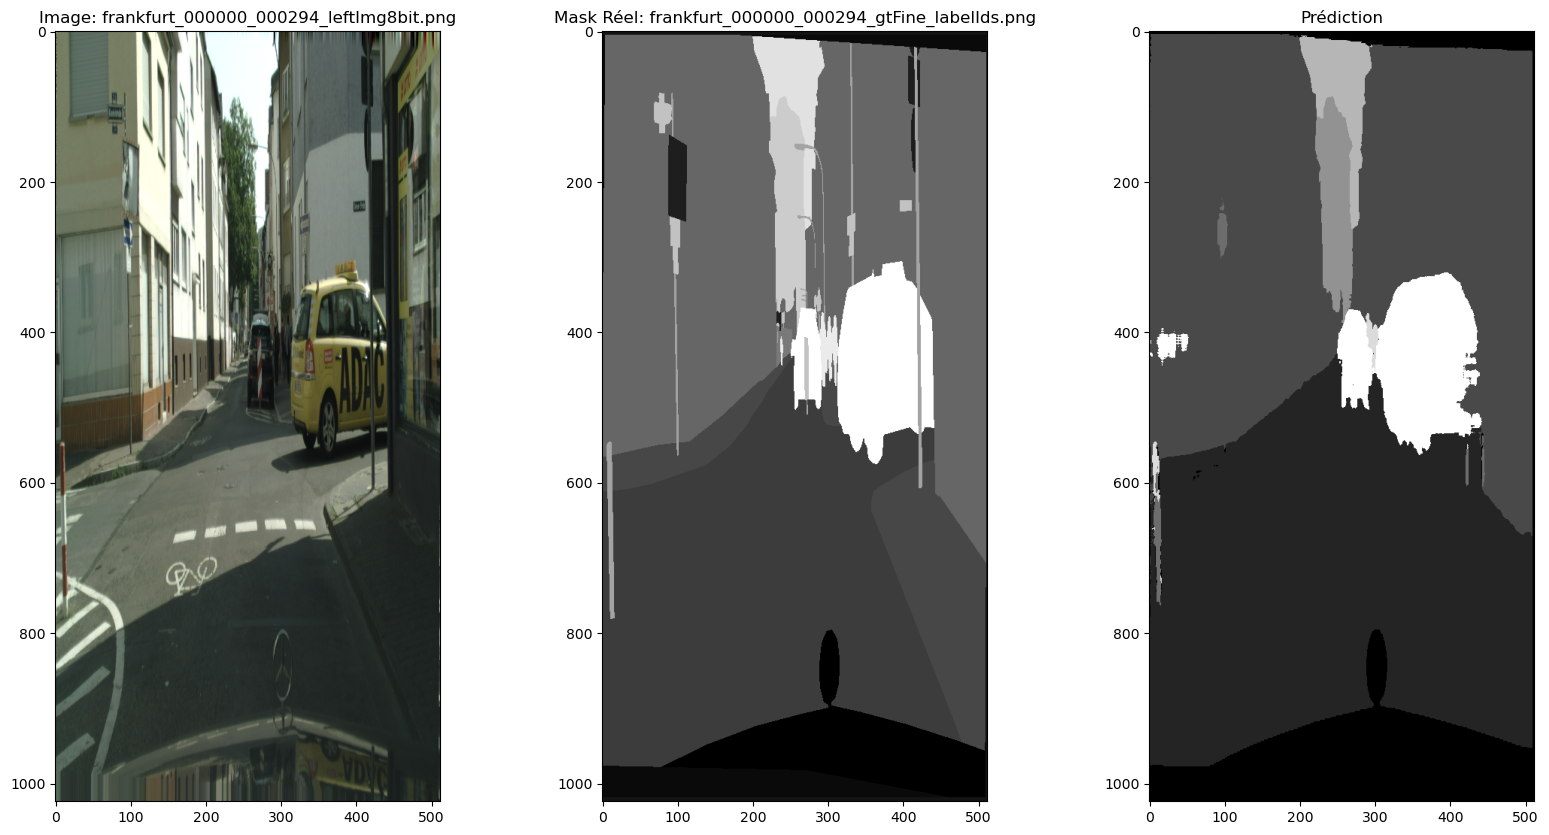

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from collections import namedtuple
import segmentation_models as sm
import cv2
from tensorflow.keras.utils import to_categorical
from albumentations import Compose, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, ShiftScaleRotate, PadIfNeeded, RandomCrop, RandomRotate90, GaussNoise, ElasticTransform, RandomGamma

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', ['name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'])

# Liste complète des labels
LABELS = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
CATEGORY_MAPPING = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

def map_category(label):
    new_category = CATEGORY_MAPPING.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
GROUPED_LABELS = [map_category(label) for label in LABELS]

# Chemins des images redimensionnées pour l'entraînement et la validation
TRAIN_IMAGES_DIR_LEFT = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
TRAIN_IMAGES_DIR_GTFINE = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
VAL_IMAGES_DIR_LEFT = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
VAL_IMAGES_DIR_GTFINE = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

def get_image_paths(directory, suffix="_leftImg8bit.png"):
    return [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files if file.endswith(suffix)]

def get_mask_paths(directory, suffix="_gtFine_labelIds.png"):
    return get_image_paths(directory, suffix)

def verify_image_mask_pairs(image_paths, mask_paths):
    if len(image_paths) != len(mask_paths):
        print("Erreur : Le nombre d'images et de masques ne correspond pas.")
        return False

    for image_path, mask_path in zip(image_paths, mask_paths):
        image_name = os.path.basename(image_path)
        mask_name = os.path.basename(mask_path)
        image_prefix = image_name.split('_leftImg8bit.png')[0]
        mask_prefix = mask_name.split('_gtFine_labelIds.png')[0]

        if image_prefix != mask_prefix:
            print(f"Erreur : L'image {image_name} ne correspond pas au masque {mask_name}.")
            return False

    print("Toutes les paires image/mask correspondent.")
    return True

def load_image(image_path, target_size=(1024, 512)):
    try:
        img = keras.preprocessing.image.load_img(image_path, target_size=target_size)
        img = keras.preprocessing.image.img_to_array(img)
        return img / 255.0
    except Exception as e:
        print(f"Warning: {image_path} is corrupted or cannot be loaded. Skipping this file.")
        return None

def load_mask(mask_path, target_size=(1024, 512)):
    try:
        img = keras.preprocessing.image.load_img(mask_path, target_size=target_size, color_mode="grayscale")
        return keras.preprocessing.image.img_to_array(img)
    except Exception as e:
        print(f"Warning: {mask_path} is corrupted or cannot be loaded. Skipping this file. Error: {e}")
        return None

def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)
    for label in LABELS:
        new_mask[mask == label.id] = label.categoryId
    return new_mask

def visualize_sample(image, mask, image_path, mask_path):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(image.astype('uint8'))
    axs[0].set_title(f'Image: {os.path.basename(image_path)}')
    axs[0].axis('off')
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title(f'Mask: {os.path.basename(mask_path)}')
    axs[1].axis('off')
    plt.show()

# Augmentation des données
transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.3),
    RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    RandomGamma(gamma_limit=(90, 110), p=0.3),
    ElasticTransform(alpha=1, sigma=25, p=0.2),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    RandomRotate90(p=0.3),
    PadIfNeeded(min_height=1024, min_width=512, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    RandomCrop(height=1024, width=512, p=1.0)
], p=0.75)

def data_generator(image_paths, mask_paths, batch_size, visualize=False):
    index = 0
    first_batch = True

    if not image_paths or not mask_paths:
        print("Warning: No data available for generating batches.")
        return

    shuffle_indices = np.arange(len(image_paths))
    np.random.shuffle(shuffle_indices)

    while True:
        batch_images = []
        batch_masks = []
        augmented_count = 0

        for _ in range(batch_size):
            if index >= len(image_paths):
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]
            mask_path = mask_paths[shuffled_idx]

            img = load_image(image_path)
            mask = load_mask(mask_path)

            if img is None or mask is None:
                index += 1
                continue

            if img.shape[:2] != mask.shape[:2]:
                print(f"Warning: Image and mask dimensions do not match for {image_path}")
                index += 1
                continue

            mask = apply_category_mapping(mask)
            mask = to_categorical(mask, num_classes=8).astype(np.float32)

            if img.shape[:2] != (1024, 512) or mask.shape[:2] != (1024, 512):
                print(f"Warning: Image or mask dimensions are incorrect for {image_path}")
                index += 1
                continue

            batch_images.append(img)
            batch_masks.append(mask)

            if np.random.rand() < 0.75:
                augmented = transform(image=img.copy(), mask=mask.copy())
                img_augmented = augmented['image']
                mask_augmented = augmented['mask']

                batch_images.append(img_augmented)
                batch_masks.append(mask_augmented)
                augmented_count += 1

            index += 1

        if not batch_images or not batch_masks:
            print("Warning: Empty batch generated")
            continue

        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):
                visualize_sample(batch_images[i], np.argmax(batch_masks[i], axis=-1), image_path, mask_path)
            first_batch = False

        #print(f"Augmented {augmented_count} out of {len(batch_images)} images in this batch.")

        yield np.array(batch_images), np.array(batch_masks)

def optimized_unet_model(dropout_rate=0.3):
    inputs = layers.Input((1024, 512, 3))

    # Contracting path
    c1 = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Dropout(dropout_rate)(c1)
    c1 = layers.Conv2D(16, (3, 3), padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Dropout(dropout_rate)(c2)
    c2 = layers.Conv2D(32, (3, 3), padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Dropout(dropout_rate)(c3)
    c3 = layers.Conv2D(64, (3, 3), padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Dropout(dropout_rate)(c4)
    c4 = layers.Conv2D(128, (3, 3), padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Dropout(dropout_rate)(c5)
    c5 = layers.Conv2D(256, (3, 3), padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    # Expanding path
    u6 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(128, (3, 3), padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Dropout(dropout_rate)(c6)
    c6 = layers.Conv2D(128, (3, 3), padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    u7 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(64, (3, 3), padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Dropout(dropout_rate)(c7)
    c7 = layers.Conv2D(64, (3, 3), padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)

    u8 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(32, (3, 3), padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Dropout(dropout_rate)(c8)
    c8 = layers.Conv2D(32, (3, 3), padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)

    u9 = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(16, (3, 3), padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Dropout(dropout_rate)(c9)
    c9 = layers.Conv2D(16, (3, 3), padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)

    outputs = layers.Conv2D(8, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs, outputs)
    return model

# Initialisation des métriques de segmentation
iou_metric = sm.metrics.IOUScore(threshold=0.5)
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur
initial_learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Initialisation du modèle
model = optimized_unet_model()

# Compilation du modèle avec les métriques de segmentation et la perte CategoricalCELoss
model.compile(
    optimizer=optimizer,
    loss=sm.losses.CategoricalCELoss(),
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

print("U-Net model compiled successfully with CategoricalCELoss.")

# Paramètres d'entraînement
batch_size = 16
epochs = 100

# Récupération des images et masques pour l'entraînement et la validation
train_images_paths = get_image_paths(TRAIN_IMAGES_DIR_LEFT)
train_mask_paths = get_mask_paths(TRAIN_IMAGES_DIR_GTFINE)

val_images_paths = get_image_paths(VAL_IMAGES_DIR_LEFT)
val_mask_paths = get_mask_paths(VAL_IMAGES_DIR_GTFINE)

# Triez les chemins pour vous assurer qu'ils sont dans le même ordre
train_images_paths.sort()
train_mask_paths.sort()
val_images_paths.sort()
val_mask_paths.sort()

# Vérification des paires image/mask
if verify_image_mask_pairs(train_images_paths, train_mask_paths):
    print("Les paires image/mask d'entraînement sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask d'entraînement.")

if verify_image_mask_pairs(val_images_paths, val_mask_paths):
    print("Les paires image/mask de validation sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask de validation.")

# Vérification des chemins d'images et de masques
print(f"Number of training images: {len(train_images_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_images_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

# Générateurs de données pour l'entraînement et la validation
train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

callbacks = [
    ModelCheckpoint('unet_model_best_iou_aug.keras', monitor='iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='iou_score', factor=0.25, patience=2, verbose=1),
    EarlyStopping(monitor='iou_score', patience=5, verbose=1, mode='max'),  # Ajout du mode ici
    keras.callbacks.LearningRateScheduler(lambda epoch: initial_learning_rate * (0.9 ** epoch))
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // (batch_size // 2),
    validation_data=val_gen if len(val_images_paths) > 0 else None,
    validation_steps=len(val_images_paths) // (batch_size // 2) if len(val_images_paths) > 0 else None,
    epochs=epochs,
    callbacks=callbacks
)

# Visualisation des métriques
def plot_metrics(history):
    metrics = ['loss', 'iou_score', 'f1-score', 'accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history[metric], label='Train')
        if 'val_' + metric in history.history:
            plt.plot(history.history['val_' + metric], label='Val', linestyle='--')
        plt.title(metric.replace('_', ' ').capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

plot_metrics(history)

def load_and_preprocess_image(image_path, target_size=(1024, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    return tf.cast(image, tf.float32) / 255.0

def load_and_preprocess_mask(mask_path, target_size=(1024, 512)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size, method='nearest')
    return tf.cast(mask, tf.int32)

def visualize_prediction(image_path, mask_path, model):
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_mask = np.argmax(prediction, axis=-1)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title(f"Mask Réel: {os.path.basename(mask_path)}")
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')
    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)


## Récapitulatif

In [46]:
from tabulate import tabulate

# Données
data = {
    "Métrique": [
        "accuracy", "f1-score", "iou_score", "loss",
        "val_accuracy", "val_f1-score", "val_iou_score",
        "val_loss", "learning_rate"
    ],
    "Sans Augmentation": [
        0.9001, 0.6865, 0.6418, 0.0397,
        0.8720, 0.6706, 0.5979, 0.0583,
        1.9967e-05
    ],
    "Avec Augmentation": [
        0.9017, 0.7187, 0.6796, 0.0353,
        0.8709, 0.6947, 0.6232, 0.0526,
        1.9967e-05
    ]
}

# Déterminer la colonne avec le iou_score le plus élevé
iou_scores = {
    "Sans Augmentation": data["Sans Augmentation"][2],
    "Avec Augmentation": data["Avec Augmentation"][2]
}
best_iou_column = max(iou_scores, key=iou_scores.get)

# Déterminer la colonne avec le val_iou_score le plus élevé
val_iou_scores = {
    "Sans Augmentation": data["Sans Augmentation"][6],
    "Avec Augmentation": data["Avec Augmentation"][6]
}
best_val_iou_column = max(val_iou_scores, key=val_iou_scores.get)

# Mettre en surbrillance le iou_score et le val_iou_score
if best_iou_column == "Sans Augmentation":
    data["Sans Augmentation"][2] = f"\033[92m{data['Sans Augmentation'][2]:.4f}\033[0m"
else:
    data["Avec Augmentation"][2] = f"\033[92m{data['Avec Augmentation'][2]:.4f}\033[0m"

if best_val_iou_column == "Sans Augmentation":
    data["Sans Augmentation"][6] = f"\033[92m{data['Sans Augmentation'][6]:.4f}\033[0m"
else:
    data["Avec Augmentation"][6] = f"\033[92m{data['Avec Augmentation'][6]:.4f}\033[0m"

# Création du tableau
table = tabulate(data, headers="keys", tablefmt="grid")
print(table)


+---------------+---------------------+---------------------+
| Métrique      |   Sans Augmentation |   Avec Augmentation |
+===============+=====================+=====================+
| accuracy      |          0.9001     |          0.9017     |
+---------------+---------------------+---------------------+
| f1-score      |          0.6865     |          0.7187     |
+---------------+---------------------+---------------------+
| iou_score     |          0.6418     |          0.6796     |
+---------------+---------------------+---------------------+
| loss          |          0.0397     |          0.0353     |
+---------------+---------------------+---------------------+
| val_accuracy  |          0.872      |          0.8709     |
+---------------+---------------------+---------------------+
| val_f1-score  |          0.6706     |          0.6947     |
+---------------+---------------------+---------------------+
| val_iou_score |          0.5979     |          0.6232     |
+-------

# UNET + resnet

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from collections import namedtuple
import segmentation_models as sm
import cv2
from tensorflow.keras.utils import to_categorical
from albumentations import (
    RandomGamma, GaussNoise, ElasticTransform, RandomRotate90,
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, ShiftScaleRotate, PadIfNeeded, RandomCrop, Compose
)
from tensorflow.keras.applications import ResNet50

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

def get_image_paths(directory, suffix="_leftImg8bit.png"):
    image_paths = [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files if file.endswith(suffix)]
    return image_paths

def verify_image_mask_pairs(image_paths, mask_paths):
    if len(image_paths) != len(mask_paths):
        print("Erreur : Le nombre d'images et de masques ne correspond pas.")
        return False

    for image_path, mask_path in zip(image_paths, mask_paths):
        image_name = os.path.basename(image_path)
        mask_name = os.path.basename(mask_path)
        image_prefix = image_name.split('_leftImg8bit.png')[0]
        mask_prefix = mask_name.split('_gtFine_labelIds.png')[0]

        if image_prefix != mask_prefix:
            print(f"Erreur : L'image {image_name} ne correspond pas au masque {mask_name}.")
            return False

    print("Toutes les paires image/mask correspondent.")
    return True

def load_and_preprocess(path, target_size=(1024, 512), color_mode="rgb"):
    try:
        img = keras.preprocessing.image.load_img(path, target_size=target_size, color_mode=color_mode)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255.0 if color_mode == "rgb" else img.astype(np.float32)
        return img
    except Exception as e:
        print(f"Warning: {path} is corrupted or cannot be loaded. Skipping this file.")
        return None

def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)
    for label in labels:
        new_mask[mask == label.id] = label.categoryId
    return new_mask.astype(np.uint8)

def visualize_sample(image, mask, image_path, mask_path):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(image.astype('uint8'))
    axs[0].set_title(f'Image: {os.path.basename(image_path)}')
    axs[0].axis('off')
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title(f'Mask: {os.path.basename(mask_path)}')
    axs[1].axis('off')
    plt.show()

transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.3),
    RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    RandomGamma(gamma_limit=(90, 110), p=0.3),
    ElasticTransform(alpha=1, sigma=25, p=0.2),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    RandomRotate90(p=0.3),
    PadIfNeeded(min_height=1024, min_width=512, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    RandomCrop(height=1024, width=512, p=1.0)
], p=0.75)

def data_generator(image_paths, mask_paths, batch_size, visualize=False):
    index = 0
    first_batch = True

    if not image_paths or not mask_paths:
        print("Warning: No data available for generating batches.")
        return

    shuffle_indices = np.arange(len(image_paths))
    np.random.shuffle(shuffle_indices)

    while True:
        batch_images = []
        batch_masks = []
        augmented_count = 0

        for _ in range(batch_size):
            if index >= len(image_paths):
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]
            mask_path = mask_paths[shuffled_idx]

            img = load_and_preprocess(image_path)
            mask = load_and_preprocess(mask_path, color_mode="grayscale")

            if img is None or mask is None:
                index += 1
                continue

            if img.shape[:2] != mask.shape[:2]:
                print(f"Warning: Image and mask dimensions do not match for {image_path}")
                index += 1
                continue

            mask = apply_category_mapping(mask)
            mask = to_categorical(mask, num_classes=8).astype(np.float32)

            if img.shape[:2] != (1024, 512) or mask.shape[:2] != (1024, 512):
                print(f"Warning: Image or mask dimensions are incorrect for {image_path}")
                index += 1
                continue

            batch_images.append(img)
            batch_masks.append(mask)

            if np.random.rand() < 0.75:  # 75% chance d'augmenter l'image
                augmented = transform(image=img.copy(), mask=mask.copy())
                img_augmented = augmented['image']
                mask_augmented = augmented['mask']

                batch_images.append(img_augmented)
                batch_masks.append(mask_augmented)
                augmented_count += 1

            index += 1

        if not batch_images or not batch_masks:
            print("Warning: Empty batch generated")
            continue

        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):
                visualize_sample(batch_images[i], np.argmax(batch_masks[i], axis=-1), image_path, mask_path)
            first_batch = False

        #print(f"Augmented {augmented_count} out of {len(batch_images)} images in this batch.")

        yield np.array(batch_images), np.array(batch_masks)

def unet_resnet50_optimise(taille_entree=(1024, 512, 3), taux_abandon=0.5):
    modele_base = ResNet50(weights='imagenet', include_top=False, input_shape=taille_entree)

    # Déverrouiller les dernières couches du modèle de base pour le fine-tuning
    for couche in modele_base.layers[-10:]:
        couche.trainable = True

    c1 = modele_base.get_layer('conv1_relu').output
    c2 = modele_base.get_layer('conv2_block3_out').output
    c3 = modele_base.get_layer('conv3_block4_out').output
    c4 = modele_base.get_layer('conv4_block6_out').output
    c5 = modele_base.get_layer('conv5_block3_out').output

    # Encodeur
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Dropout(taux_abandon)(c6)
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    # Décodeur
    u6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c6)
    u6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Dropout(taux_abandon)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Dropout(taux_abandon)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Dropout(taux_abandon)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Dropout(taux_abandon)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)

    u10 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c9)
    sorties = layers.Conv2D(8, (1, 1), activation='softmax')(u10)

    modele = models.Model(inputs=modele_base.input, outputs=sorties)

    return modele

# Initialisation des métriques de segmentation
iou_metric = sm.metrics.IOUScore(threshold=0.5)
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur
initial_learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Initialisation du modèle
model = unet_resnet50_optimise()

# Compilation du modèle avec les métriques de segmentation et la perte CategoricalCELoss
model.compile(
    optimizer=optimizer,
    loss=sm.losses.CategoricalCELoss(),
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

print("U-Net model with ResNet50 encoder compiled successfully with CategoricalCELoss.")

# Paramètres d'entraînement
batch_size = 16
epochs = 100

# Récupération des images et masques pour l'entraînement et la validation
train_images_paths = get_image_paths(train_images_dir_left)
train_mask_paths = get_image_paths(train_images_dir_gtfine, suffix="_gtFine_labelIds.png")

val_images_paths = get_image_paths(val_images_dir_left)
val_mask_paths = get_image_paths(val_images_dir_gtfine, suffix="_gtFine_labelIds.png")

# Triez les chemins pour vous assurer qu'ils sont dans le même ordre
train_images_paths.sort()
train_mask_paths.sort()
val_images_paths.sort()
val_mask_paths.sort()

# Vérification des paires image/mask
if verify_image_mask_pairs(train_images_paths, train_mask_paths):
    print("Les paires image/mask d'entraînement sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask d'entraînement.")

if verify_image_mask_pairs(val_images_paths, val_mask_paths):
    print("Les paires image/mask de validation sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask de validation.")

# Vérification des chemins d'images et de masques
print(f"Number of training images: {len(train_images_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_images_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

# Générateurs de données pour l'entraînement et la validation
train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

# Callbacks
callbacks = [
    ModelCheckpoint('unet_resnet_model_best_iou.keras', monitor='iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='iou_score', factor=0.25, patience=2, verbose=1),
    EarlyStopping(monitor='iou_score', patience=5, verbose=1, mode='max'),  # Ajout du mode ici
    keras.callbacks.LearningRateScheduler(lambda epoch: initial_learning_rate * (0.9 ** epoch))
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // (batch_size // 2),
    validation_data=val_gen if len(val_images_paths) > 0 else None,
    validation_steps=len(val_images_paths) // (batch_size // 2) if len(val_images_paths) > 0 else None,
    epochs=epochs,
    callbacks=callbacks
)

# Visualisation des métriques
def plot_metrics(history):
    metrics = ['loss', 'iou_score', 'f1-score', 'accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history[metric], label='Train')
        if 'val_' + metric in history.history:
            plt.plot(history.history['val_' + metric], label='Val', linestyle='--')
        plt.title(metric.replace('_', ' ').capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

plot_metrics(history)

def load_and_preprocess_image(image_path, target_size=(1024, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_and_preprocess_mask(mask_path, target_size=(1024, 512)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size, method='nearest')
    mask = tf.cast(mask, tf.int32)
    return mask

def visualize_prediction(image_path, mask_path, model):
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_mask = np.argmax(prediction, axis=-1)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title(f"Mask Réel: {os.path.basename(mask_path)}")
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')
    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)


# EfficientNet + FPN

## Categorical Crossentropy loss

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from collections import namedtuple
import segmentation_models as sm
from albumentations import Compose, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, RandomGamma, ShiftScaleRotate, PadIfNeeded, RandomCrop
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical
import cv2

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', ['name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void', 1: 'flat', 2: 'construction', 3: 'object', 4: 'nature', 5: 'sky', 6: 'human', 7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name, id=label.id, trainId=label.trainId, category=new_category,
        categoryId=label.categoryId, hasInstances=label.hasInstances, ignoreInEval=label.ignoreInEval, color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

def get_image_paths(directory, suffix="_leftImg8bit.png"):
    return [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files if file.endswith(suffix)]

def verify_image_mask_pairs(image_paths, mask_paths):
    if len(image_paths) != len(mask_paths):
        print("Erreur : Le nombre d'images et de masques ne correspond pas.")
        return False

    for image_path, mask_path in zip(image_paths, mask_paths):
        image_name = os.path.basename(image_path)
        mask_name = os.path.basename(mask_path)
        if image_name.split('_leftImg8bit.png')[0] != mask_name.split('_gtFine_labelIds.png')[0]:
            print(f"Erreur : L'image {image_name} ne correspond pas au masque {mask_name}.")
            return False

    print("Toutes les paires image/mask correspondent.")
    return True

def load_and_preprocess(path, target_size=(1024, 512), color_mode="rgb"):
    try:
        img = keras.preprocessing.image.load_img(path, target_size=target_size, color_mode=color_mode)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255.0 if color_mode == "rgb" else img.astype(np.float32)
        return img
    except Exception as e:
        print(f"Warning: {path} is corrupted or cannot be loaded. Skipping this file.")
        return None

def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)
    for label in labels:
        new_mask[mask == label.id] = label.categoryId
    return new_mask.astype(np.uint8)

def visualize_sample(image, mask, image_path, mask_path):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(image.astype('uint8'))
    axs[0].set_title(f'Image: {os.path.basename(image_path)}')
    axs[0].axis('off')
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title(f'Mask: {os.path.basename(mask_path)}')
    axs[1].axis('off')
    plt.show()

# Définir les transformations d'augmentation avec une probabilité globale de 0.75
transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.3),
    RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    RandomGamma(gamma_limit=(90, 110), p=0.3),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    PadIfNeeded(min_height=1024, min_width=512, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    RandomCrop(height=1024, width=512, p=1.0)
], p=0.75)

def data_generator(image_paths, mask_paths, batch_size, visualize=False):
    index = 0
    first_batch = True

    if not image_paths or not mask_paths:
        print("Warning: No data available for generating batches.")
        return

    shuffle_indices = np.arange(len(image_paths))
    np.random.default_rng().shuffle(shuffle_indices)

    while True:
        batch_images = []
        batch_masks = []
        augmented_count = 0
        for _ in range(batch_size):
            if index >= len(image_paths):
                index = 0
                np.random.default_rng().shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]
            mask_path = mask_paths[shuffled_idx]

            img = load_and_preprocess(image_path)
            mask = load_and_preprocess(mask_path, color_mode="grayscale")

            if img is None or mask is None:
                index += 1
                continue

            if img.shape[:2] != mask.shape[:2]:
                print(f"Warning: Image and mask dimensions do not match for {image_path}")
                index += 1
                continue

            mask = apply_category_mapping(mask)
            mask = to_categorical(mask, num_classes=8).astype(np.float32)

            if img.shape[:2] != (1024, 512) or mask.shape[:2] != (1024, 512):
                print(f"Warning: Image or mask dimensions are incorrect for {image_path}")
                index += 1
                continue

            batch_images.append(img)
            batch_masks.append(mask)

            if np.random.rand() < 0.75:
                augmented = transform(image=img.copy(), mask=mask.copy())
                img_augmented = augmented['image']
                mask_augmented = augmented['mask']

                batch_images.append(img_augmented)
                batch_masks.append(mask_augmented)
                augmented_count += 1

            index += 1

        if not batch_images or not batch_masks:
            print("Warning: Empty batch generated")
            continue

        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):
                visualize_sample(batch_images[i], np.argmax(batch_masks[i], axis=-1), image_path, mask_path)
            first_batch = False

        #print(f"Augmented {augmented_count} out of {len(batch_images)} images in this batch.")

        yield np.array(batch_images), np.array(batch_masks)

def efficientnet_fpn_optimized(input_size=(1024, 512, 3), dropout_rate=0.3):
    base_model = EfficientNetB0(include_top=False, input_shape=input_size, weights='imagenet')

    # Déverrouillez certaines couches pour le fine-tuning
    for layer in base_model.layers[-12:]:
        layer.trainable = True

    c1 = base_model.get_layer('block2a_expand_activation').output
    c2 = base_model.get_layer('block3a_expand_activation').output
    c3 = base_model.get_layer('block4a_expand_activation').output
    c4 = base_model.get_layer('block6a_expand_activation').output
    c5 = base_model.get_layer('top_activation').output

    p5 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(c5)
    p4 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(c4) + layers.UpSampling2D()(p5)
    p3 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(c3) + layers.UpSampling2D()(p4)
    p2 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(c2) + layers.UpSampling2D()(p3)

    u6 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(p5)
    u6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(dropout_rate)(c6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(dropout_rate)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(dropout_rate)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(dropout_rate)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    u10 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c9)
    outputs = layers.Conv2D(8, (1, 1), activation='softmax', dtype='float32')(u10)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Initialisation des métriques de segmentation
iou_metric = sm.metrics.IOUScore(threshold=0.5)
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Initialisation du modèle optimisé
model_optimized = efficientnet_fpn_optimized()

# Compilation du modèle avec les métriques de segmentation et la perte CategoricalCELoss
model_optimized.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=sm.losses.CategoricalCELoss(),
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

print("EfficientNetB0 with FPN optimized model compiled successfully with CategoricalCELoss.")

# Paramètres d'entraînement
batch_size = 16
epochs = 100

# Récupération des images et masques pour l'entraînement et la validation
train_images_paths = get_image_paths(train_images_dir_left)
train_mask_paths = get_image_paths(train_images_dir_gtfine, suffix="_gtFine_labelIds.png")

val_images_paths = get_image_paths(val_images_dir_left)
val_mask_paths = get_image_paths(val_images_dir_gtfine, suffix="_gtFine_labelIds.png")

# Triez les chemins pour vous assurer qu'ils sont dans le même ordre
train_images_paths.sort()
train_mask_paths.sort()
val_images_paths.sort()
val_mask_paths.sort()

# Vérification des paires image/mask
if verify_image_mask_pairs(train_images_paths, train_mask_paths):
    print("Les paires image/mask d'entraînement sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask d'entraînement.")

if verify_image_mask_pairs(val_images_paths, val_mask_paths):
    print("Les paires image/mask de validation sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask de validation.")

# Vérification des chemins d'images et de masques
print(f"Number of training images: {len(train_images_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_images_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

# Générateurs de données pour l'entraînement et la validation
train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

# Callbacks
callbacks = [
    ModelCheckpoint('eff_fpn_model_best_iou.keras', monitor='iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='iou_score', factor=0.25, patience=2, verbose=1),
    EarlyStopping(monitor='iou_score', patience=5, verbose=1, mode='max'),  # Ajout du mode ici
    keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * (0.9 ** epoch))
]

# Entraînement du modèle
history = model_optimized.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // (batch_size // 2),
    validation_data=val_gen if len(val_images_paths) > 0 else None,
    validation_steps=len(val_images_paths) // (batch_size // 2) if len(val_images_paths) > 0 else None,
    epochs=epochs,
    callbacks=callbacks
)

# Visualisation des métriques
def plot_metrics(history):
    import matplotlib.pyplot as plt
    metrics = ['loss', 'iou_score', 'f1-score', 'accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history[metric], label='Train')
        if 'val_' + metric in history.history:
            plt.plot(history.history['val_' + metric], label='Val', linestyle='--')
        plt.title(metric.replace('_', ' ').capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

plot_metrics(history)

def visualize_prediction(image_path, mask_path, model):
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    image = load_and_preprocess(image_path)
    mask = load_and_preprocess(mask_path, color_mode="grayscale")

    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_mask = np.argmax(prediction, axis=-1)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title(f"Mask Réel: {os.path.basename(mask_path)}")
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')
    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model_optimized)


EfficientNetB0 with FPN optimized model compiled successfully with CategoricalCELoss.
Toutes les paires image/mask correspondent.
Les paires image/mask d'entraînement sont correctement appariées.
Toutes les paires image/mask correspondent.
Les paires image/mask de validation sont correctement appariées.
Number of training images: 2975
Number of training masks: 2975
Number of validation images: 500
Number of validation masks: 500
Epoch 1/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.5689 - f1-score: 0.3079 - iou_score: 0.2291 - loss: 0.1501 
Epoch 1: iou_score improved from -inf to 0.40129, saving model to eff_fpn_model_best_iou.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 8751s 24s/step - accuracy: 0.5694 - f1-score: 0.3083 - iou_score: 0.2296 - loss: 0.1499 - val_accuracy: 0.5284 - val_f1-score: 0.2201 - val_iou_score: 0.1524 - val_loss: 0.2356 - learning_rate: 1.0000e-04
Epoch 2/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8743 - f1-score: 0.6277 - iou_score: 0.5805 

## Loss combinée

### Dice + loss

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from collections import namedtuple
import segmentation_models as sm
import cv2
from tensorflow.keras.utils import to_categorical
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, RandomGamma,
    ElasticTransform, ShiftScaleRotate, RandomRotate90, PadIfNeeded, RandomCrop
)
from tensorflow.keras.applications import EfficientNetB0

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

def get_image_paths(directory, suffix="_leftImg8bit.png"):
    return [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files if file.endswith(suffix)]

def verify_image_mask_pairs(image_paths, mask_paths):
    if len(image_paths) != len(mask_paths):
        print("Erreur : Le nombre d'images et de masques ne correspond pas.")
        return False

    for image_path, mask_path in zip(image_paths, mask_paths):
        image_name = os.path.basename(image_path)
        mask_name = os.path.basename(mask_path)
        image_prefix = image_name.split('_leftImg8bit.png')[0]
        mask_prefix = mask_name.split('_gtFine_labelIds.png')[0]

        if image_prefix != mask_prefix:
            print(f"Erreur : L'image {image_name} ne correspond pas au masque {mask_name}.")
            return False

    print("Toutes les paires image/mask correspondent.")
    return True

def load_and_preprocess(path, target_size=(1024, 512), color_mode="rgb"):
    try:
        img = keras.preprocessing.image.load_img(path, target_size=target_size, color_mode=color_mode)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255.0 if color_mode == "rgb" else img.astype(np.float32)
        return img
    except Exception as e:
        print(f"Warning: {path} is corrupted or cannot be loaded. Skipping this file.")
        return None

def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)
    for label in labels:
        new_mask[mask == label.id] = label.categoryId
    return new_mask.astype(np.uint8)

def visualize_sample(image, mask, image_path, mask_path):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(image.astype('uint8'))
    axs[0].set_title(f'Image: {os.path.basename(image_path)}')
    axs[0].axis('off')
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title(f'Mask: {os.path.basename(mask_path)}')
    axs[1].axis('off')
    plt.show()

# Définir les transformations d'augmentation avec une probabilité globale de 0.75
transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.3),
    RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    RandomGamma(gamma_limit=(90, 110), p=0.3),
    ElasticTransform(alpha=1, sigma=25, p=0.2),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    RandomRotate90(p=0.3),
    PadIfNeeded(min_height=1024, min_width=512, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    RandomCrop(height=1024, width=512, p=1.0)
], p=0.75)

def data_generator(image_paths, mask_paths, batch_size, visualize=False):
    index = 0
    first_batch = True

    if not image_paths or not mask_paths:
        print("Warning: No data available for generating batches.")
        return

    shuffle_indices = np.arange(len(image_paths))
    np.random.shuffle(shuffle_indices)

    while True:
        batch_images = []
        batch_masks = []
        augmented_count = 0

        for _ in range(batch_size):
            if index >= len(image_paths):
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]
            mask_path = mask_paths[shuffled_idx]

            img = load_and_preprocess(image_path)
            mask = load_and_preprocess(mask_path, color_mode="grayscale")

            if img is None or mask is None:
                index += 1
                continue

            if img.shape[:2] != mask.shape[:2]:
                print(f"Warning: Image and mask dimensions do not match for {image_path}")
                index += 1
                continue

            mask = apply_category_mapping(mask)
            mask = to_categorical(mask, num_classes=8).astype(np.float32)

            if img.shape[:2] != (1024, 512) or mask.shape[:2] != (1024, 512):
                print(f"Warning: Image or mask dimensions are incorrect for {image_path}")
                index += 1
                continue

            batch_images.append(img)
            batch_masks.append(mask)

            if np.random.rand() < 0.75:  # 75% chance d'augmenter l'image
                augmented = transform(image=img.copy(), mask=mask.copy())
                img_augmented = augmented['image']
                mask_augmented = augmented['mask']

                batch_images.append(img_augmented)
                batch_masks.append(mask_augmented)
                augmented_count += 1

            index += 1

        if not batch_images or not batch_masks:
            print("Warning: Empty batch generated")
            continue

        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):
                visualize_sample(batch_images[i], np.argmax(batch_masks[i], axis=-1), image_path, mask_path)
            first_batch = False

        #print(f"Augmented {augmented_count} out of {len(batch_images)} images in this batch.")

        yield np.array(batch_images), np.array(batch_masks)

def efficientnet_fpn(input_size=(1024, 512, 3), dropout_rate=0.3):
    base_model = EfficientNetB0(include_top=False, input_shape=input_size, weights='imagenet')

    # Déverrouiller certaines couches pour le fine-tuning
    for layer in base_model.layers[-12:]:
        layer.trainable = True

    c1 = base_model.get_layer('block2a_expand_activation').output
    c2 = base_model.get_layer('block3a_expand_activation').output
    c3 = base_model.get_layer('block4a_expand_activation').output
    c4 = base_model.get_layer('block6a_expand_activation').output
    c5 = base_model.get_layer('top_activation').output

    p5 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(c5)
    p4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(c4) + layers.UpSampling2D()(p5)
    p3 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(c3) + layers.UpSampling2D()(p4)
    p2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(c2) + layers.UpSampling2D()(p3)

    u6 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(p5)
    u6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(dropout_rate)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(dropout_rate)(c7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(dropout_rate)(c8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(dropout_rate)(c9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    u10 = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c9)
    outputs = layers.Conv2D(8, (1, 1), activation='softmax', dtype='float32')(u10)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Définir la fonction de perte combinée
def combined_loss(y_true, y_pred):
    dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.1, 1, 1, 1, 1, 1, 1, 1]))
    categorical_loss = sm.losses.CategoricalCELoss()
    return dice_loss(y_true, y_pred) + categorical_loss(y_true, y_pred)

# Initialisation des métriques de segmentation
iou_metric = sm.metrics.IOUScore(threshold=0.5)
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur
initial_learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Initialisation du modèle
model = efficientnet_fpn()

# Compilation du modèle avec les métriques de segmentation et la perte combinée
model.compile(
    optimizer=optimizer,
    loss=combined_loss,
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

print("EfficientNetB0 with FPN model compiled successfully with combined loss.")

# Paramètres d'entraînement
batch_size = 16
epochs = 100

# Récupération des images et masques pour l'entraînement et la validation
train_images_paths = get_image_paths(train_images_dir_left)
train_mask_paths = get_image_paths(train_images_dir_gtfine, suffix="_gtFine_labelIds.png")

val_images_paths = get_image_paths(val_images_dir_left)
val_mask_paths = get_image_paths(val_images_dir_gtfine, suffix="_gtFine_labelIds.png")

# Triez les chemins pour vous assurer qu'ils sont dans le même ordre
train_images_paths.sort()
train_mask_paths.sort()
val_images_paths.sort()
val_mask_paths.sort()

# Vérification des paires image/mask
if verify_image_mask_pairs(train_images_paths, train_mask_paths):
    print("Les paires image/mask d'entraînement sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask d'entraînement.")

if verify_image_mask_pairs(val_images_paths, val_mask_paths):
    print("Les paires image/mask de validation sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask de validation.")

# Vérification des chemins d'images et de masques
print(f"Number of training images: {len(train_images_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_images_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

# Générateurs de données pour l'entraînement et la validation
train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

# Callbacks
callbacks = [
    ModelCheckpoint('eff_fpn_model_best_diceloss.keras', monitor='iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='iou_score', factor=0.25, patience=2, verbose=1),
    EarlyStopping(monitor='iou_score', patience=5, verbose=1, mode='max'),  # Ajout du mode ici
    keras.callbacks.LearningRateScheduler(lambda epoch: initial_learning_rate * (0.9 ** epoch))
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // (batch_size // 2),
    validation_data=val_gen if len(val_images_paths) > 0 else None,
    validation_steps=len(val_images_paths) // (batch_size // 2) if len(val_images_paths) > 0 else None,
    epochs=epochs,
    callbacks=callbacks
)

# Visualisation des métriques
def plot_metrics(history):
    metrics = ['loss', 'iou_score', 'f1-score', 'accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history[metric], label='Train')
        if 'val_' + metric in history.history:
            plt.plot(history.history['val_' + metric], label='Val', linestyle='--')
        plt.title(metric.replace('_', ' ').capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

plot_metrics(history)

def load_and_preprocess_image(image_path, target_size=(1024, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_and_preprocess_mask(mask_path, target_size=(1024, 512)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size, method='nearest')
    mask = tf.cast(mask, tf.int32)
    return mask

def visualize_prediction(image_path, mask_path, model):
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_mask = np.argmax(prediction, axis=-1)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title(f"Mask Réel: {os.path.basename(mask_path)}")
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')
    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)


### Iou + Loss

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from collections import namedtuple
import segmentation_models as sm
import cv2
from tensorflow.keras.utils import to_categorical
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, RandomGamma,
    ElasticTransform, ShiftScaleRotate, RandomRotate90, PadIfNeeded, RandomCrop
)
from tensorflow.keras.applications import EfficientNetB0

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

def get_image_paths(directory, suffix="_leftImg8bit.png"):
    return [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files if file.endswith(suffix)]

def verify_image_mask_pairs(image_paths, mask_paths):
    if len(image_paths) != len(mask_paths):
        print("Erreur : Le nombre d'images et de masques ne correspond pas.")
        return False

    for image_path, mask_path in zip(image_paths, mask_paths):
        image_name = os.path.basename(image_path)
        mask_name = os.path.basename(mask_path)
        image_prefix = image_name.split('_leftImg8bit.png')[0]
        mask_prefix = mask_name.split('_gtFine_labelIds.png')[0]

        if image_prefix != mask_prefix:
            print(f"Erreur : L'image {image_name} ne correspond pas au masque {mask_name}.")
            return False

    print("Toutes les paires image/mask correspondent.")
    return True

def load_and_preprocess(path, target_size=(1024, 512), color_mode="rgb"):
    try:
        img = keras.preprocessing.image.load_img(path, target_size=target_size, color_mode=color_mode)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255.0 if color_mode == "rgb" else img.astype(np.float32)
        return img
    except Exception as e:
        print(f"Warning: {path} is corrupted or cannot be loaded. Skipping this file.")
        return None

def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)
    for label in labels:
        new_mask[mask == label.id] = label.categoryId
    return new_mask.astype(np.uint8)

def visualize_sample(image, mask, image_path, mask_path):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(image.astype('uint8'))
    axs[0].set_title(f'Image: {os.path.basename(image_path)}')
    axs[0].axis('off')
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title(f'Mask: {os.path.basename(mask_path)}')
    axs[1].axis('off')
    plt.show()

# Définir les transformations d'augmentation avec une probabilité globale de 0.75
transform = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.3),
    RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    RandomGamma(gamma_limit=(90, 110), p=0.3),
    ElasticTransform(alpha=1, sigma=25, p=0.2),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    RandomRotate90(p=0.3),
    PadIfNeeded(min_height=1024, min_width=512, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    RandomCrop(height=1024, width=512, p=1.0)
], p=0.75)

def data_generator(image_paths, mask_paths, batch_size, visualize=False):
    index = 0
    first_batch = True

    if not image_paths or not mask_paths:
        print("Warning: No data available for generating batches.")
        return

    shuffle_indices = np.arange(len(image_paths))
    np.random.shuffle(shuffle_indices)

    while True:
        batch_images = []
        batch_masks = []
        augmented_count = 0

        for _ in range(batch_size):
            if index >= len(image_paths):
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]
            mask_path = mask_paths[shuffled_idx]

            img = load_and_preprocess(image_path)
            mask = load_and_preprocess(mask_path, color_mode="grayscale")

            if img is None or mask is None:
                index += 1
                continue

            if img.shape[:2] != mask.shape[:2]:
                print(f"Warning: Image and mask dimensions do not match for {image_path}")
                index += 1
                continue

            mask = apply_category_mapping(mask)
            mask = to_categorical(mask, num_classes=8).astype(np.float32)

            if img.shape[:2] != (1024, 512) or mask.shape[:2] != (1024, 512):
                print(f"Warning: Image or mask dimensions are incorrect for {image_path}")
                index += 1
                continue

            batch_images.append(img)
            batch_masks.append(mask)

            if np.random.rand() < 0.75:  # 75% chance d'augmenter l'image
                augmented = transform(image=img.copy(), mask=mask.copy())
                img_augmented = augmented['image']
                mask_augmented = augmented['mask']

                batch_images.append(img_augmented)
                batch_masks.append(mask_augmented)
                augmented_count += 1

            index += 1

        if not batch_images or not batch_masks:
            print("Warning: Empty batch generated")
            continue

        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):
                visualize_sample(batch_images[i], np.argmax(batch_masks[i], axis=-1), image_path, mask_path)
            first_batch = False

        #print(f"Augmented {augmented_count} out of {len(batch_images)} images in this batch.")

        yield np.array(batch_images), np.array(batch_masks)

def efficientnet_fpn(input_size=(1024, 512, 3), dropout_rate=0.3):
    base_model = EfficientNetB0(include_top=False, input_shape=input_size, weights='imagenet')

    # Déverrouiller certaines couches pour le fine-tuning
    for layer in base_model.layers[-12:]:
        layer.trainable = True

    c1 = base_model.get_layer('block2a_expand_activation').output
    c2 = base_model.get_layer('block3a_expand_activation').output
    c3 = base_model.get_layer('block4a_expand_activation').output
    c4 = base_model.get_layer('block6a_expand_activation').output
    c5 = base_model.get_layer('top_activation').output

    p5 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(c5)
    p4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(c4) + layers.UpSampling2D()(p5)
    p3 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(c3) + layers.UpSampling2D()(p4)
    p2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(c2) + layers.UpSampling2D()(p3)

    u6 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(p5)
    u6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(dropout_rate)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(dropout_rate)(c7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(dropout_rate)(c8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(dropout_rate)(c9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    u10 = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c9)
    outputs = layers.Conv2D(8, (1, 1), activation='softmax', dtype='float32')(u10)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Définir la fonction de perte combinée en utilisant segmentation_models
jaccard_loss = sm.losses.JaccardLoss()
categorical_crossentropy = sm.losses.CategoricalCELoss()
cce_jaccard_loss = categorical_crossentropy + jaccard_loss

# Initialisation des métriques de segmentation
iou_metric = sm.metrics.IOUScore(threshold=0.5)
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur
initial_learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Initialisation du modèle
model = efficientnet_fpn()

# Compilation du modèle avec les métriques de segmentation et la perte combinée
model.compile(
    optimizer=optimizer,
    loss=cce_jaccard_loss,
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

print("EfficientNetB0 with FPN model compiled successfully with combined CCE and Jaccard loss.")

# Paramètres d'entraînement
batch_size = 16
epochs = 100

# Récupération des images et masques pour l'entraînement et la validation
train_images_paths = get_image_paths(train_images_dir_left)
train_mask_paths = get_image_paths(train_images_dir_gtfine, suffix="_gtFine_labelIds.png")

val_images_paths = get_image_paths(val_images_dir_left)
val_mask_paths = get_image_paths(val_images_dir_gtfine, suffix="_gtFine_labelIds.png")

# Triez les chemins pour vous assurer qu'ils sont dans le même ordre
train_images_paths.sort()
train_mask_paths.sort()
val_images_paths.sort()
val_mask_paths.sort()

# Vérification des paires image/mask
if verify_image_mask_pairs(train_images_paths, train_mask_paths):
    print("Les paires image/mask d'entraînement sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask d'entraînement.")

if verify_image_mask_pairs(val_images_paths, val_mask_paths):
    print("Les paires image/mask de validation sont correctement appariées.")
else:
    print("Il y a des incohérences dans les paires image/mask de validation.")

# Vérification des chemins d'images et de masques
print(f"Number of training images: {len(train_images_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_images_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

# Générateurs de données pour l'entraînement et la validation
train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

# Callbacks
callbacks = [
    ModelCheckpoint('eff_fpn_model_best_combined_iou_loss.keras', monitor='iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='iou_score', factor=0.25, patience=2, verbose=1),
    EarlyStopping(monitor='iou_score', patience=5, verbose=1, mode='max'),  # Ajout du mode ici
    keras.callbacks.LearningRateScheduler(lambda epoch: initial_learning_rate * (0.9 ** epoch))
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // (batch_size // 2),
    validation_data=val_gen if len(val_images_paths) > 0 else None,
    validation_steps=len(val_images_paths) // (batch_size // 2) if len(val_images_paths) > 0 else None,
    epochs=epochs,
    callbacks=callbacks
)

# Visualisation des métriques
def plot_metrics(history):
    metrics = ['loss', 'iou_score', 'f1-score', 'accuracy']
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history[metric], label='Train')
        if 'val_' + metric in history.history:
            plt.plot(history.history['val_' + metric], label='Val', linestyle='--')
        plt.title(metric.replace('_', ' ').capitalize())
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

plot_metrics(history)

def load_and_preprocess_image(image_path, target_size=(1024, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_and_preprocess_mask(mask_path, target_size=(1024, 512)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size, method='nearest')
    mask = tf.cast(mask, tf.int32)
    return mask

def visualize_prediction(image_path, mask_path, model):
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_mask = np.argmax(prediction, axis=-1)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title(f"Mask Réel: {os.path.basename(mask_path)}")
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')
    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)


## Récapitulatif